In [5]:
import random
import argparse
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator as ea
# import more_itertools

from matplotlib import pyplot as plt
from matplotlib import colors as colors
import seaborn as sns
import numpy as np

import glob
import os
import re
import json

# %matplotlib inline

# Normalizing by substracting the minimum value of each reward component (It's not necesserily the best normalizing method)

In [5]:
# set font size of the scientific notation properly
# see https://stackoverflow.com/questions/21512305/inconsistent-font-size-for-scientific-notation-in-axis
plt.rc('font', size=18)                

def get_num_of_steps(model_path_glob):
    episode_length_path = os.path.join(os.path.dirname(model_path_glob), 'episode_length.txt')
    with open(episode_length_path) as episode_length_file:
        episode_length = episode_length_file.read()
    return float(episode_length)
    
def create_plot(model_path_glob, normalize=True, limit=2.0e6, old=False):
    """
    Plot all normalized rewards per step
    """
    titles_map = ['Diversity', 'Coherency', 'Interestingness']
    
    num_of_steps = get_num_of_steps(model_path_glob)
    raw_smooth_space = 10
    smooth_space = 20
    reward_tags = ['diversity', 'coherency', 'interestingness', 'back', 'empty_display', 'empty_groupings', 'same_display_seen_already', 'snorkel_humanity']
    if old:
        reward_tags = ['diversity', 'humanity', 'interestingness', 'back', 'empty_display', 'empty_groupings', 'same_display_seen_already']

    x_list = []
    y_list = []
    x_list_raw = []
    y_list_raw = []

    for i, tag in enumerate(reward_tags):
        # only support scalar now
        #log_path = params['logdir']
        possible_model_paths = glob.glob(model_path_glob)
        assert len(possible_model_paths) == 1
        model_path = possible_model_paths[0]
        acc = ea.EventAccumulator(model_path)
        acc.Reload()
        scalar_list = acc.Tags()['scalars']
        #print(scalar_list)
        x = [int(s.step) for s in acc.Scalars(tag)]
        y = [s.value for s in acc.Scalars(tag)]
    

        # smooth curve
        x_ = []
        y_ = []
        for i in range(0, len(x), smooth_space):
            x_.append(x[i])
            y_vals = y[max(0, i - smooth_space):i + smooth_space]
            y_.append(sum(y_vals) / float(len(y_vals)))
            
        x_raw_smoothed = []
        y_raw_smoothed = []
        for i in range(0, len(x), raw_smooth_space):
            x_raw_smoothed.append(x[i])
            y_vals = y[max(0, i - raw_smooth_space):i + raw_smooth_space]
            y_raw_smoothed.append(sum(y_vals) / float(len(y_vals)))

        x_list.append(x_)
        y_list.append(y_)

        # raw curve
        x_list_raw.append(x_raw_smoothed)
        y_list_raw.append(y_raw_smoothed)


    # Add back, empty display and empty groupings to interestingness
    # Add same_display_seen_already to diversity
    reward_tags = ['diversity', 'coherency', 'interestingness']
    
    y_list[2] = [y_list[2][i] + y_list[3][i] +  y_list[4][i] +  y_list[5][i] for i in range(len(y_list[2]))]
    y_list_raw[2] = [y_list_raw[2][i] + y_list_raw[3][i] + y_list_raw[4][i] + y_list_raw[5][i] for i in range(len(y_list_raw[2]))]
    
    y_list[0] = [y_list[0][i] + y_list[6][i] for i in range(len(y_list[0]))]
    y_list_raw[0] = [y_list_raw[0][i] + y_list_raw[6][i] for i in range(len(y_list_raw[0]))]
    
    y_list = y_list[:3]
    y_list_raw = y_list_raw[:3]
    x_list = x_list[:3]
    x_list_raw = x_list_raw[:3]
    
    epsilons = [0.01, 0.05, 0.1]
    con_steps = [[], [], []]
    structure_true = -1
    
    # Minimum and maximum values
    for i, tag in enumerate(reward_tags):

        min_tag = min(y_list[i])
        max_tag = max(y_list[i])
#         print(f'{tag}: min={min_tag}, max={max_tag}')
        if normalize or tag == 'diversity':
            substract_val = min_tag
        else:
            substract_val = 0
        y_list[i] = [(y_val - substract_val) for y_val in y_list[i]]
        y_list_raw[i] = [(y_val - substract_val) for y_val in y_list_raw[i]]
        
#         if tag == 'coherency':
#             y_list[i] = [y_val / (num_of_steps*5*3) for y_val in y_list[i]]
#             y_list_raw[i] = [y_val / (num_of_steps*5*3) for y_val in y_list_raw[i]]
        
#         # Find convergence point
#         for e in range(len(epsilons)):
#             for j in range(len(y_list[i])):
#                 if max(y_list[i][j:]) <= (min(y_list[i][j:]) + 2*epsilons[e]):
#                     con_steps[e].append(x_list[i][j])
#                     break
        # Find structure spot
#         if tag == 'coherency' and not old:
#             for j in range(len(y_list[i])):
#                 if y_list[i][j] >= 0:
#                     structure_true = j
#                     break
            
#     for e in range(len(epsilons)):
#         print(f'Total convergence of {epsilons[e]} is at {max(con_steps[e])}')
    
    return x_list, y_list, structure_true

In [ ]:
# set font size of the scientific notation properly
# see https://stackoverflow.com/questions/21512305/inconsistent-font-size-for-scientific-notation-in-axis
plt.rc('font', size=18)
    
def compare_rewards_plot(ax, dataset, model_path_globs, normalize=False, limit=2.0e6, tasks=None, 
                         disable_cache=False, custom_cycler=None):
    """
    Plot all normalized rewards per step
    """
    titles_map = tasks
    
#     plt.figure()
    
    # Change figure size (https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib)
    plt.gcf().set_size_inches(16.0, 8.0)
    
    if custom_cycler is not None:
        ax.set_prop_cycle(color=custom_cycler)
    
    for axis_num, mpg in enumerate(model_path_globs):
        path = os.path.join(os.path.dirname(mpg), 'cache.json')
        if os.path.exists(path) and not disable_cache:
            with open(path, 'r') as f:
                cache = json.load(f)
            x_list = cache['x']
            y_list = cache['y']
            structure_true = -1
        else:
            x_list, y_list, structure_true = create_plot(mpg, normalize, limit, old=('old' in titles_map[axis_num]))
            assert len(set(map(tuple, x_list))) == 1
            x_list = x_list[0]
            y_list = list(map(sum, zip(*y_list)))
            max_val = max(y_list)
            y_list = [i/max_val for i in y_list]

            path = os.path.join(os.path.dirname(mpg), 'cache.json')
            with open(path, 'w') as f:
                json.dump({'x': x_list, 'y': y_list}, f)

        if titles_map[axis_num] == 'ATENA':
            ax.plot(x_list, y_list, linewidth=4.2, label=titles_map[axis_num])
        else:
            ax.plot(x_list, y_list, linewidth=3.5, label=titles_map[axis_num])
        ax.set_title(dataset, fontsize=26)
        if structure_true != -1:  
            print(x_list[structure_true])
            ax.plot(x_list[structure_true],y_list[structure_true], ls="", marker="D", color='k')

# Full

<function matplotlib.pyplot.show(close=None, block=None)>

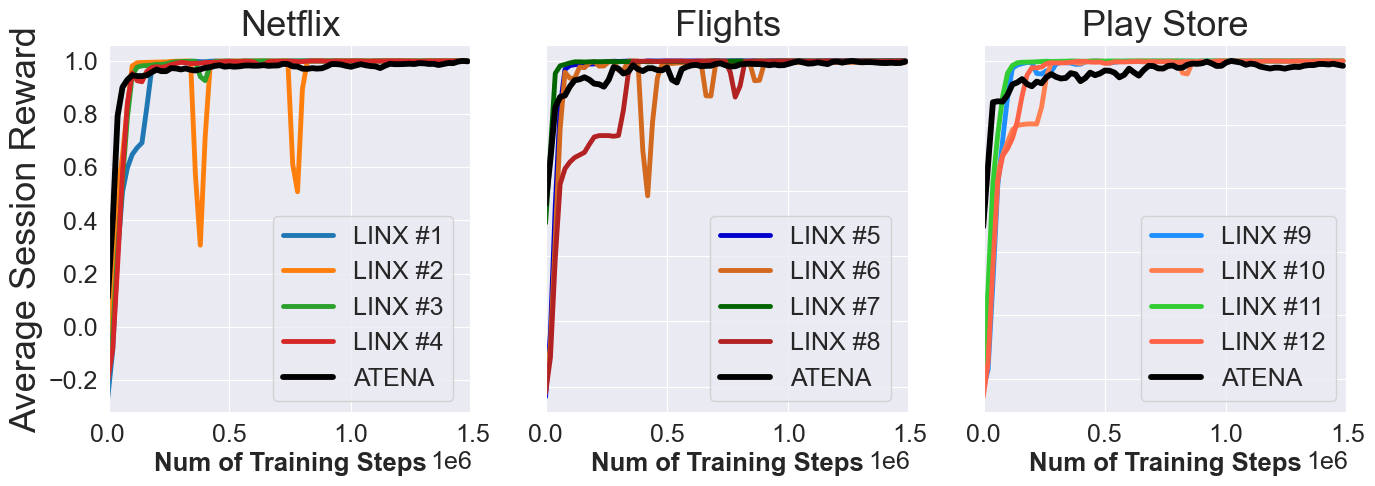

In [60]:
fig, axs = plt.subplots(1, 3)
# fig.suptitle('Learning Curves')
limit = 1500000
SYSTEM_NAME = 'LINX'
NUM_COLORS = 16

cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
ATENA_COLOR = 'k'
custom_cyclers = [list(c) + [ATENA_COLOR] for c in [['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], 
                                                    ['mediumblue', 'chocolate', 'darkgreen', 'firebrick'],
                                                    ['dodgerblue', 'coral', 'limegreen', 'tomato'] 
                                                    ]]

# NETFLIX
compare_rewards_plot(axs[0], 'Netflix', [r'linx_events\20211230T175037.856085\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220105T142016.670026\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220218T210559.183443\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220222T153045.530578\events.out.tfevents.*.rack-milo-01',
                     r'atena_events\20220226T131233.635196\events.out.tfevents.*.rack-milo-01'],
                    tasks=[f'{SYSTEM_NAME} #1', f'{SYSTEM_NAME} #2', f'{SYSTEM_NAME} #3', f'{SYSTEM_NAME} #4', 'ATENA'], 
                     limit=1500000, custom_cycler=custom_cyclers[0])

# FLIGHTS
compare_rewards_plot(axs[1], 'Flights', [r'linx_events\20211230T101024.205543\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220127T135514.370862\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220216T164124.971137\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220225T232157.880294\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220123T112410.270005\events.out.tfevents.*.rack-milo-01'],
                    tasks=[f'{SYSTEM_NAME} #5', f'{SYSTEM_NAME} #6', f'{SYSTEM_NAME} #7', f'{SYSTEM_NAME} #8', 'ATENA'], 
                     limit=1500000, custom_cycler=custom_cyclers[1])

# PLAY STORE
compare_rewards_plot(axs[2], 'Play Store', [r'linx_events\20220225T215727.516569\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220215T213937.967484\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220220T153948.033917\events.out.tfevents.*.rack-milo-01',
                     r'linx_events\20220220T175856.535400\events.out.tfevents.*.rack-milo-01',
                     r'atena_events\20220213T191447.857566\events.out.tfevents.*.rack-milo-01'],
                    tasks=[f'{SYSTEM_NAME} #9', f'{SYSTEM_NAME} #10', f'{SYSTEM_NAME} #11', f'{SYSTEM_NAME} #12', 'ATENA'], 
                     limit=1500000, custom_cycler=custom_cyclers[2])

for ax in axs.flat:
    ax.set_xlabel("Num of Training Steps", fontsize=18.5, fontweight='bold')
    ax.set_ylabel("Average Session Reward", fontsize=26)
    ax.set_xlim(0, limit)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    plt.setp(ax.spines.values(), linewidth=3)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
#     ax.set_yticks([-0.2 ,  0.04,  0.28,  0.52,  0.76])
#     ax.set_yticklabels(['' ,  0.04,  0.28,  0.52,  0.76])
#     ax.set_ylabels(['a','b','c','d','e'])
#     ax.set_yticks([-0.2 , -0.08,  0.04,  0.16,  0.28,  0.4 ,  0.52,  0.64,  0.76, 0.88, 1])
    
    # Shrink y axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height * 0.6])
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.7, 0.57), ncol=1, fancybox=True)
    
#     ax.title()

# Put a legend to the right of the current axis
# axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
#           ncol=3, fancybox=True)

# # change ticks font sizes
# plt.tick_params(labelsize=12)

for ax in axs.flat:
    ax.label_outer()
    
# plt.tight_layout()
plt.savefig("convergance_plot.pdf",format='pdf',dpi=2000,bbox_inches='tight')
plt.show

In [5]:
from tensorflow.python.data.experimental.ops.data_service_ops import distribute

NUM_COLORS = 13

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
x = [list(i) for i in distribute(3, colors[:-1])]
print(x)
print(colors)
ax.set_prop_cycle(color=(x[0] + x[1] + x[2] + [colors[-1]]))
for i in range(NUM_COLORS):
    ax.plot(np.arange(10)*(i+1))

fig.savefig('moreColors.png')
plt.show()

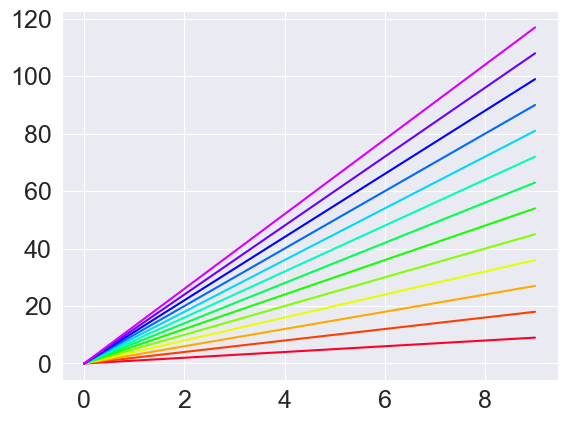

In [49]:
NUM_COLORS = 13

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
ax.set_prop_cycle(color=(colors[0:5] + colors[5:] + colors[2:12:3] + [colors[-1]]))
for i in range(NUM_COLORS):
    ax.plot(np.arange(10)*(i+1))

fig.savefig('moreColors.png')
plt.show()

In [ ]:
NUM_COLORS = 13

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
ax.set_prop_cycle(color=colors)
for i in range(NUM_COLORS):
    ax.plot(np.arange(10)*(i+1))

fig.savefig('moreColors.png')
plt.show()